# Workshop 001: Python Data Engineer

#### By: Camila Cardona Alzate

In these workshop we are going to solve the requirements stated and show the diagrams and visualizations that help us explain the solutions. We are going to use SQLAlchemy as an ORM connected to MySQL and create visualizations using pyplot from matplotlib. 

Our first step is to create the connection to the db and create the table with the corresponding columns. 

In [1]:
pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\camil\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
from sqlalchemy import Column, Integer, String, Boolean, Date, CHAR
from sqlalchemy.orm import declarative_base
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import json
import pandas as pd

with open('credentials.json', 'r') as json_file:
    data = json.load(json_file)
    user = data["user"]
    password = data["password"]
    server = data["server"]
    db = data["db"]

db_connection = f"mysql+mysqlconnector://{user}:{password}@{server}/{db}"

Base= declarative_base()

class Candidate(Base):
    __tablename__ = 'candidates'
    id = Column(Integer, primary_key=True, autoincrement=True)
    first_name = Column(String(50))
    last_name = Column(String(50))
    email = Column(String(100))
    application_date = Column(Date)
    country = Column(String(200))
    yoe = Column(Integer)
    seniority = Column(String(200))
    technology = Column(String(200))
    code_challenge_score = Column(Integer)
    technical_interview_score = Column(Integer)
    hired = Column(CHAR)

engine = create_engine(db_connection)
Base.metadata.create_all(engine)






We can confirm that the table is created: 

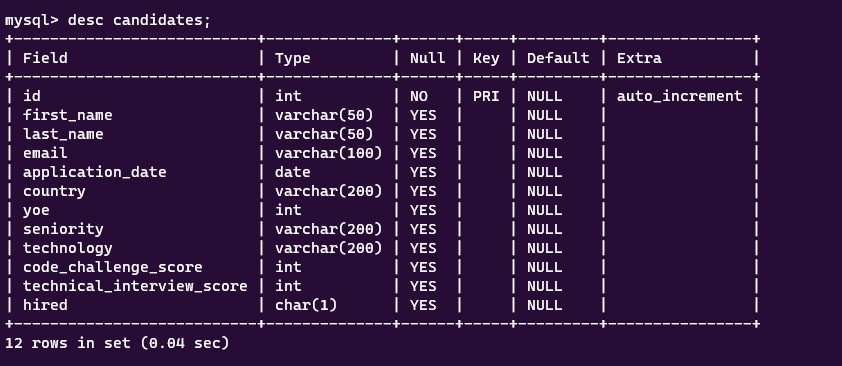

The next step is to load the csv file with the information, including the code to fill the column "hired" that indicates whether a candidate was hired ("y") or not ("n").

In [7]:
Session = sessionmaker(bind=engine)
session = Session()

data = pd.read_csv("candidates.csv", sep=';')

for _, row in data.iterrows():
    candidate = Candidate(
        first_name=row['first_name'],
        last_name=row['last_name'],
        email=row['email'],
        application_date=row['application_date'],
        country=row['country'],
        yoe=row['yoe'],
        seniority=row['seniority'],
        technology=row['technology'],
        code_challenge_score=row['code_challenge_score'],
        technical_interview_score=row['technical_interview_score']
    )
    
    # Calculate "hired" column

    if row['code_challenge_score'] >= 7 and row['technical_interview_score'] >= 7:
        candidate.hired = 'y'
    else:
        candidate.hired = 'n'
    
    session.add(candidate)


session.commit()
session.close()

Using pandas to insert the information of the csv, we can upload the information to the database: 

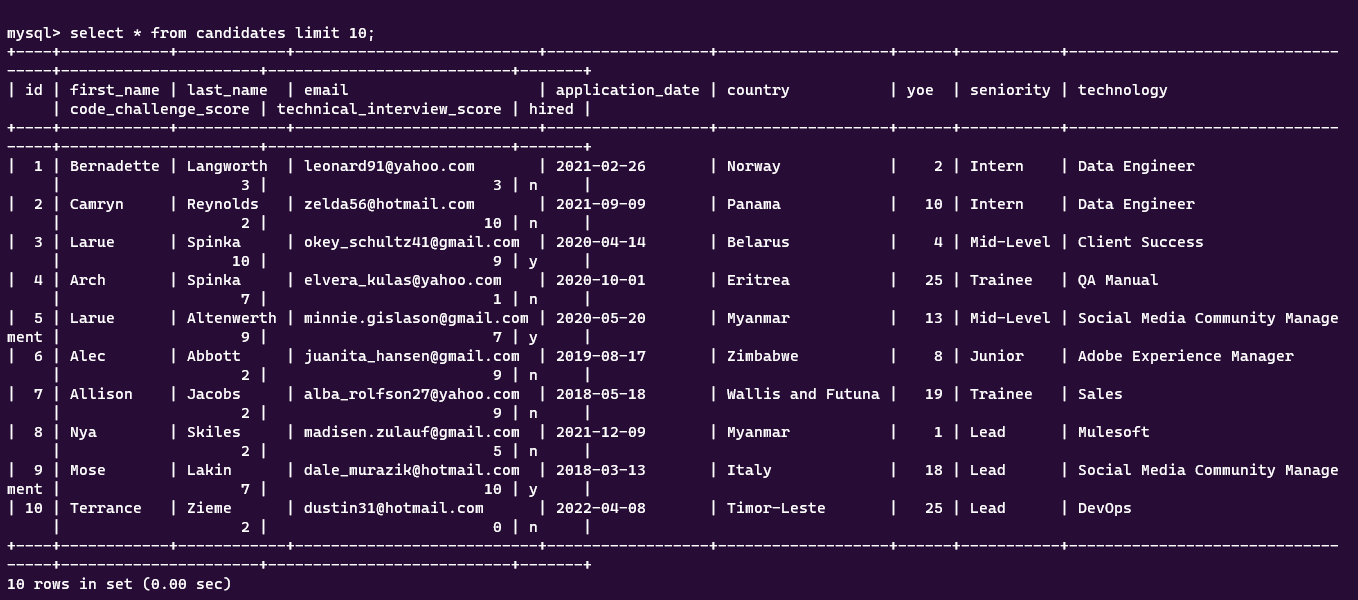

### QUERIES:

Now it's time to complete the task by creating visualizations depending the requirement.

#### 1. Hires by technology (pie chart): 

                                 Technology  Count
0                            Client Success    271
1         Social Media Community Management    237
2                     System Administration    293
3                          Game Development    519
4                                    Design    249
5                  Adobe Experience Manager    282
6                                    DevOps    495
7                                  Security    266
8   Business Analytics / Project Management    255
9                       Security Compliance    250
10                    Business Intelligence    254
11               Development - CMS Frontend    251
12                               Salesforce    256
13                   Development - Frontend    266
14                        Technical Writing    223
15                                 Mulesoft    260
16                            Data Engineer    255
17                                QA Manual    259
18                  Development

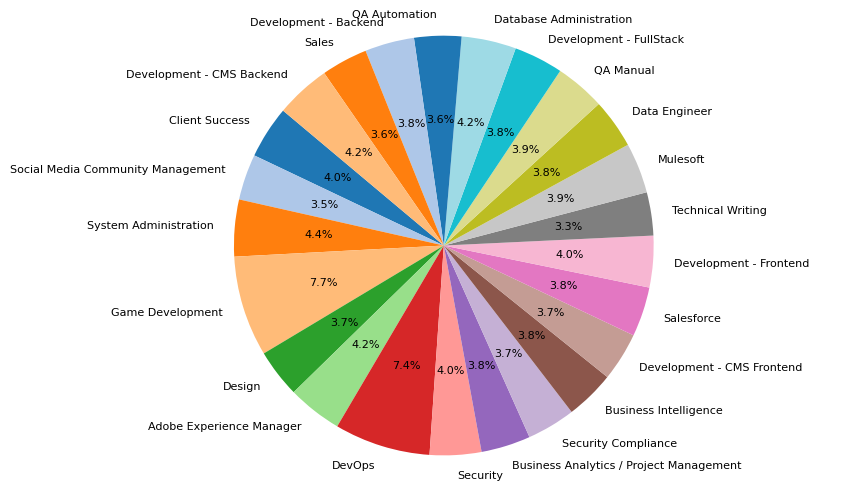

In [13]:
from sqlalchemy import func, extract
import matplotlib.pyplot as plt


Session = sessionmaker(bind=engine)
session = Session()


query = session.query(Candidate.technology, func.count(Candidate.id)).\
        filter(Candidate.hired == "y").\
        group_by(Candidate.technology).\
        all()

session.close()


df = pd.DataFrame(query, columns=['Technology', 'Count'])

print(df)

# Visualization:

colors = plt.cm.tab20.colors

fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts, autotexts = ax.pie(df['Count'], labels=df['Technology'], autopct='%1.1f%%', textprops={'fontsize': 8}, colors=colors, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()




#### 2. Hires by year (horizontal bar chart):

   year  hires
0  2018   1409
1  2019   1524
2  2020   1485
3  2021   1485
4  2022    795


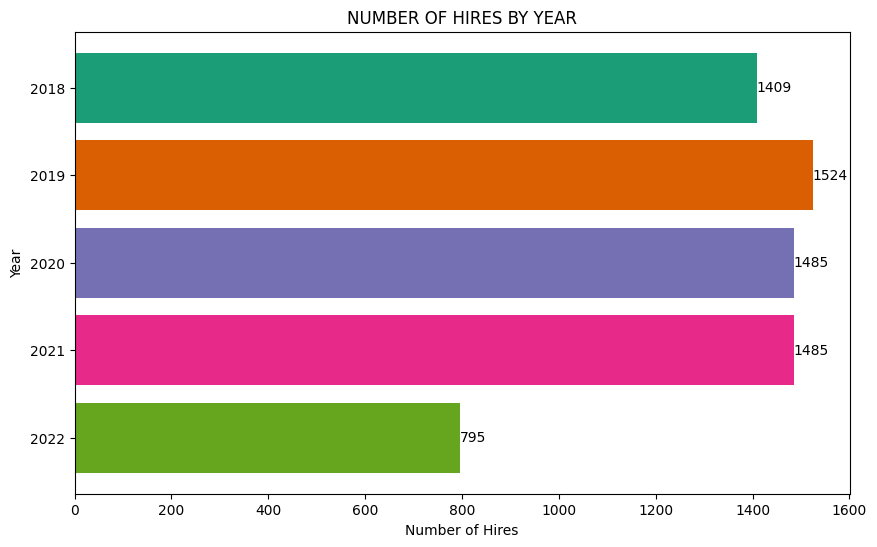

In [11]:
Session = sessionmaker(bind=engine)
session = Session()


query2 = session.query(extract('year', Candidate.application_date).label('year'), func.count(Candidate.id).label('hires')).\
        filter(Candidate.hired == 'y').\
        group_by('year').\
        order_by('year').\
        all()


session.close()


df = pd.DataFrame(query2)

print(df)

colors1 = plt.cm.Dark2.colors


# Visualization:


plt.figure(figsize=(10, 6))
bars = plt.barh(df['year'], df['hires'], color=colors1)
plt.xlabel('Number of Hires')
plt.ylabel('Year')
plt.title('NUMBER OF HIRES BY YEAR')
plt.gca().invert_yaxis()  

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width()}', 
             va='center', ha='left', fontsize=10)

plt.show()

#### 3. Hires by seniority (bar chart):

   seniority  hires
0  Mid-Level    924
1       Lead    929
2     Junior    977
3     Senior    939
4    Trainee    973
5     Intern    985
6  Architect    971


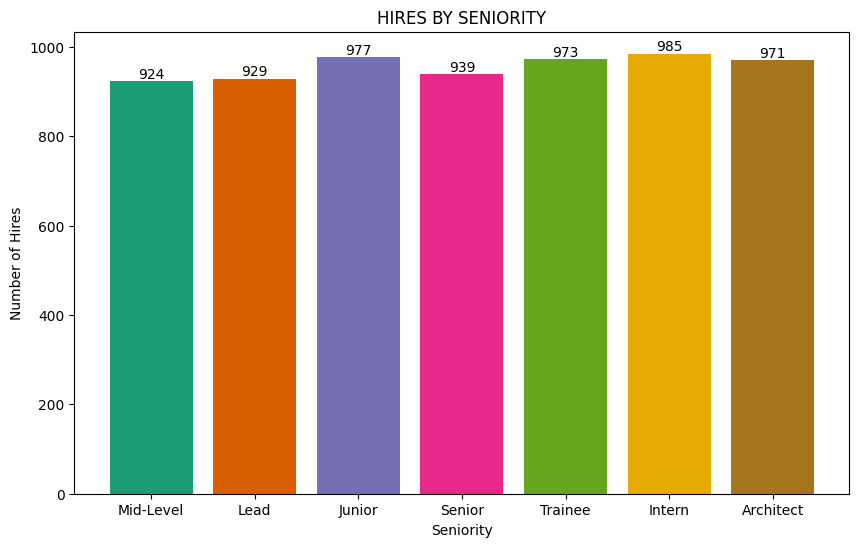

In [16]:
Session = sessionmaker(bind=engine)
session = Session()


query3 = session.query(Candidate.seniority, func.count(Candidate.id).label('hires')).\
        filter(Candidate.hired == 'y').\
        group_by(Candidate.seniority).\
        all()


session.close()


df = pd.DataFrame(query3)

print(df)

# Visualization:

plt.figure(figsize=(10, 6))
bars = plt.bar(df['seniority'], df['hires'], color= colors1)
plt.xlabel('Seniority')
plt.ylabel('Number of Hires')
plt.title('HIRES BY SENIORITY')


for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', 
             va='bottom', ha='center', fontsize=10)


plt.show()

#### 4. Hires by country over years (USA, Brazil, Colombia, and Ecuador only)(multiline chart):

    year   country  hires
0   2018    Brazil      9
1   2018  Colombia      7
2   2018   Ecuador      1
3   2019    Brazil      7
4   2019  Colombia      8
5   2019   Ecuador      3
6   2020    Brazil      6
7   2020  Colombia      8
8   2020   Ecuador      8
9   2021    Brazil      7
10  2021  Colombia      1
11  2021   Ecuador      5
12  2022    Brazil      4
13  2022  Colombia      1
14  2022   Ecuador      3


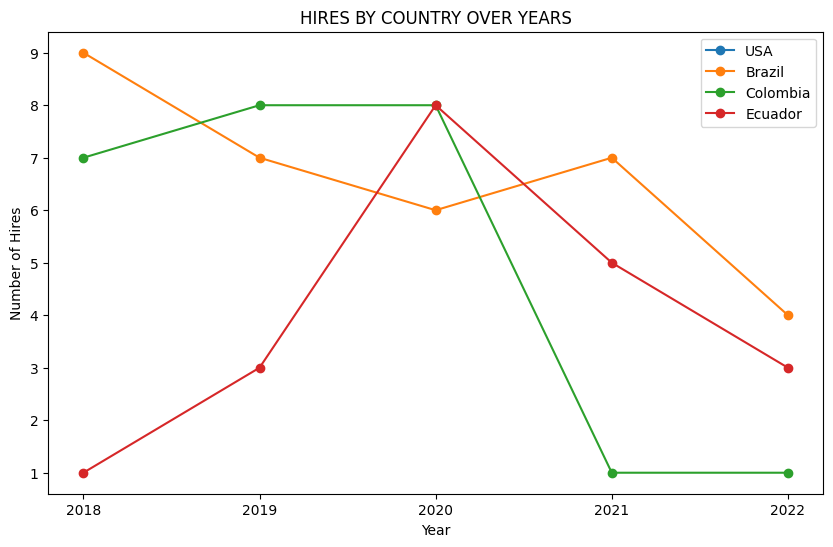

In [23]:
Session = sessionmaker(bind=engine)
session = Session()

# Define the list of countries
countries = ['USA', 'Brazil', 'Colombia', 'Ecuador']

# Execute the query using SQLAlchemy
query4 = session.query(extract('year', Candidate.application_date).label('year'),
        Candidate.country,
        func.count(Candidate.id).label('hires')).\
        filter(Candidate.hired == 'y').\
        filter(Candidate.country.in_(countries)).\
        group_by('year', 'country').\
        order_by('year').\
        all()

session.close()


df = pd.DataFrame(query4)

print(df)

#Visualization:

plt.figure(figsize=(10, 6))
for country in countries:
    country_data = df[df['country'] == country]
    plt.plot(country_data['year'], country_data['hires'], marker='o', label=country)

plt.xlabel('Year')
plt.ylabel('Number of Hires')
plt.title('HIRES BY COUNTRY OVER YEARS')
plt.legend()
plt.xticks(df['year'].unique()) 

plt.show()